### 丢弃法

深度学习模型常常使用丢弃法(dropout)来应对过拟合问题。丢弃法有一些不同的变体。本节中提到的丢弃法特指倒置丢弃法(inverted dropout)。丢弃法可以使输出层不会过度依赖某一个节点，从而在训练模型时起到正则化的作用,并可以用来应对过拟合。

**在测试模型时，我们为了拿到更加确定性的结果，一般不使用丢弃法。**

#### 方法
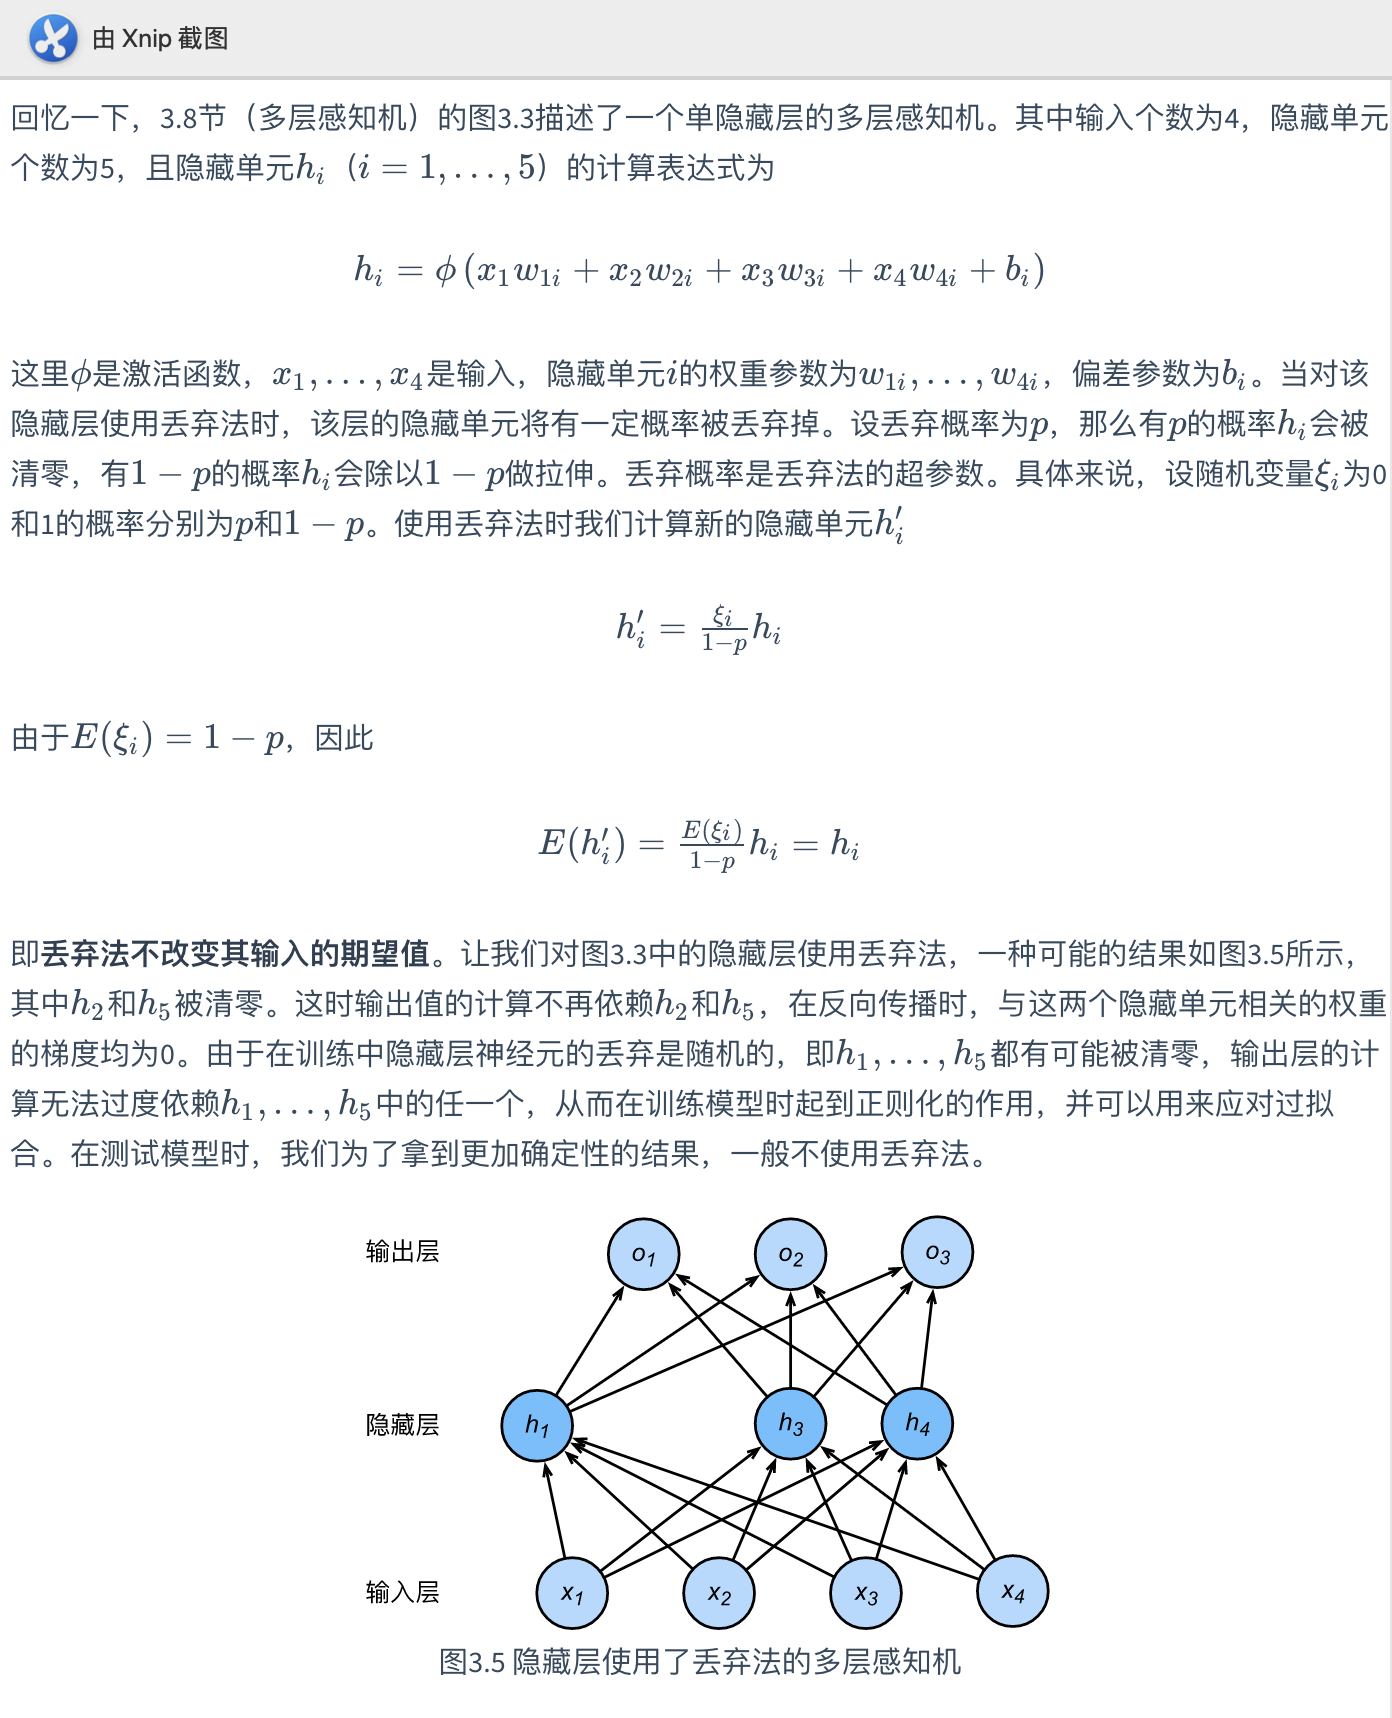

#### 从零开始实现

根据丢弃法的定义，我们可以很容易地实现它。下面的dropout函数将以drop_prob的概率丢弃X中的元素。

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys
import utils

In [2]:
#定义丢弃法实现函数
#以drop_prob的概率丢弃X中的元素
def dropout(X,drop_prob):
    #将X投射为float类型
    X=X.float()
    assert 0<=drop_prob<=1
    keep_prob=1-drop_prob
    if keep_prob==0:
        return torch.zeros_like(X)
    #torch.rand()返回[0,1)之间均匀分布的一组随机数
    mask=(torch.rand(X.shape)<keep_prob).float()
    
    return mask*X/keep_prob


In [3]:
#测试dropout函数
X=torch.arange(16).view(2,8)
dropout(X,0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [4]:
dropout(X,0.5)

tensor([[ 0.,  0.,  0.,  6.,  0., 10.,  0., 14.],
        [ 0., 18., 20.,  0.,  0.,  0., 28.,  0.]])

In [5]:
dropout(X,1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

#### 定义模型参数

实验中，我们依然使用前面介绍的Fashion-MNIST数据集。我们将定义一个包含两个隐藏层的多层感知机，其中两个隐藏层的输出个数都是256。

In [6]:
num_inputs,num_outputs,num_hidden1,num_hidden2=784,10,256,256

W1=torch.tensor(np.random.normal(0,0.01,size=(num_inputs,num_hidden1)),dtype=torch.float,requires_grad=True)
b1=torch.zeros(num_hidden1,requires_grad=True)
W2=torch.tensor(np.random.normal(0,0.01,size=(num_hidden1,num_hidden2)),dtype=torch.float,requires_grad=True)
b2=torch.zeros(num_hidden2,requires_grad=True)
W3=torch.tensor(np.random.normal(0,0.01,size=(num_hidden2,num_outputs)),dtype=torch.float,requires_grad=True)
b3=torch.zeros(num_outputs,requires_grad=True)

In [7]:
params=[W1,b1,W2,b2,W3,b3]

#### 定义模型

下面定义的模型将全连接层和激活函数ReLU串起来，并对每个激活函数的输出使用丢弃法。
我们可以分别设置各个层的丢弃概率。通常的建议是靠近输入层的丢弃概率设得小一点。
我们可以通过参数is_training函数来判断运行模为训练还是测试，并只需在训练模式下使用丢弃法。

In [8]:
#在这个实验中，我们把第一个隐藏层的丢弃概率设为0.2，把第二个隐藏层的丢弃概率设为0.5

drop_prob1,drop_prob2=0.2,0.5

def net(X,is_training=True):
    X=X.view(-1,num_inputs)
    H1=(torch.mm(X,W1)+b1).relu()
    if is_training:#只在训练模型时使用丢弃法
        H1=dropout(H1,drop_prob1) #在第一层全连接后添加丢弃层
    H2=(torch.matmul(H1,W2)+b2).relu()
    if is_training:
        H2=dropout(H2,drop_prob2) #在第二层全连接后添加丢弃层
    return torch.matmul(H2,W3)+b3

#### 训练和测试模型

In [9]:
num_epochs,lr,batch_size=5,100.0,256
loss=torch.nn.CrossEntropyLoss()
train_iter,test_iter=utils.load_data_fashion_mnist(batch_size)
utils.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1,loss 0.0046,train acc0.553,test acc 0.737
epoch 2,loss 0.0022,train acc0.793,test acc 0.812
epoch 3,loss 0.0018,train acc0.830,test acc 0.797
epoch 4,loss 0.0017,train acc0.843,test acc 0.830
epoch 5,loss 0.0015,train acc0.855,test acc 0.843


#### 简洁实现

在PyTorch中，我们只需要在全连接层后添加Dropout层并指定丢弃概率。在训练模型时，Dropout层将以指定的丢弃概率随机丢弃上一层的输出元素;

**在测试模型时,使用model.eval()后,Dropout层并不发挥作用；使用model.train()后，Dropout层才发挥作用。**

In [10]:
net=nn.Sequential(
    utils.FlattenLayer(),
    nn.Linear(num_inputs,num_hidden1),
    nn.ReLU(),
    nn.Dropout(drop_prob1),
    nn.Linear(num_hidden1,num_hidden2),
    nn.ReLU(),
    nn.Dropout(drop_prob2),
    nn.Linear(num_hidden2,10)
)

In [11]:
for param in net.parameters():
    nn.init.normal_(param,mean=0,std=0.01)

In [12]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
utils.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1,loss 0.0049,train acc0.511,test acc 0.652
epoch 2,loss 0.0023,train acc0.781,test acc 0.801
epoch 3,loss 0.0019,train acc0.823,test acc 0.826
epoch 4,loss 0.0017,train acc0.837,test acc 0.781
epoch 5,loss 0.0016,train acc0.848,test acc 0.847


### 总结

* 我们可以通过使用丢弃法应对过拟合
* 丢弃法只在训练模型时使用